In [19]:
import pprint
import json
import uuid

import random
random.seed(17)

import numpy as np
np.random.seed(17) # fix NumPy random number generator seed

import networkx as nx
import matplotlib.pyplot as plt


import os

# add some relative paths so we can import sampling.py module.
import sys
sys.path.append("../")
sys.path.append("../src")
sys_path = sys.path

import sampling

In [20]:
def is_number(x):
    """brief utility function we'll call later to filter mixed lists."""
    return isinstance(x, (int, float))


def blended_utility_score(
        instance_data: dict, 
        ranges: dict,
        weights: dict,
    ) -> float:
    
    if instance_data["metadata"]["edge_type"] == "ferromagnetic":
        # ferromagnetic has zero utility.
        # a polynomial time approximate sampling routine exists.
        return 0.0 # ferromagnetic has zero utility.

    if instance_data["metadata"]["number_of_nodes"] <= 20:
        # small instance has zero utility.
        # probability distribution can be calculated explicitly.
        return 0.0 
    
    score = 0.0
    params = ranges.keys()
    for param in params:
        v_min = ranges[param]["min"]
        v_max = ranges[param]["max"]
        r = v_max - v_min
        normalized_val = (instance_data["metadata"][param] - v_min)/r
        score += weights[param]*normalized_val
        # num nodes (bigger --> harder)
        # num edges (bigger --> harder)
        # edge density (denser --> harder)
        # max degree (larger --> harder)
        # max interaction strength (bigger --> harder)
        # max external field (bigger --> harder)

    return score # higher is better. [worst, best] == [0, 1]

def blended_performance_metric_score(
        performance_metrics_data: dict, 
        ranges: dict,
        weights: dict,
    ) -> float:

    if (not performance_metrics_data["within_time_limit"]):
        # disqualified due to time limit exceeded.
        return 1.0
    
    if (not performance_metrics_data["returned_required_num_samples_k"]):
        # disqualified due to not returning enough samples.
        return 1.0 
    
    score = 0.0
    rescaled_score_weights = 0.0
    params = ranges.keys()
    for param in params:
        
        x = performance_metrics_data[param]
        if is_number(x):
            x_min = ranges[param]["min"]
            x_max = ranges[param]["max"]
                        
            # all of our performance metrics are "lower is better"
            # but our score is "higher is better"
            # so we invert the metric as follows:
            x = (x_max - x_min) - (x - x_min) 
            # as x --> x_max, then this approaches zero (bad score)
            # as x --> x_min, then this approaches a large value (good score)

            normalized_val = x / (x_max - x_min) # now between [0,1]
            score += weights[param]*normalized_val
            rescaled_score_weights += weights[param]
        

    # it's possible that KL divergence and other metrics are NOT calculated
    # due to the size of the system.  In this case, we don't include the scores
    # for those metrics, but we don't want to penalize the overall score by leaving it
    # as zero, so we rescale.
    score /= rescaled_score_weights

    return score # higher is better. [worst, best] == [0, 1]

In [21]:
# Read in data from instances and performance_metric files

instances_relative_path = "../benchmark_instances/"
benchmark_instance_filenames = os.listdir(instances_relative_path)

performance_metrics_relative_path = "../benchmark_proctor_performance_metrics/"
performance_metrics_filenames = os.listdir(performance_metrics_relative_path)

perf_metrics_list = []
for perf_fname in performance_metrics_filenames:
    if ".json" in perf_fname:
        with open(performance_metrics_relative_path + perf_fname,"rb") as f:
            perf_metrics = json.loads(f.read())
            perf_metrics_list.append(perf_metrics)

instance_data_list = []        
for inst_fname in benchmark_instance_filenames:
    if ".json" in inst_fname:
        with open(instances_relative_path + inst_fname,"rb") as f:
            instance_data = json.loads(f.read())
            instance_data_list.append(instance_data)

print("number of benchmark instances read in:", len(instance_data_list))
print("number of performance metric files read in:", len(perf_metrics_list))


number of benchmark instances read in: 17
number of performance metric files read in: 15


In [22]:
# calculate "ranges" (i.e., min, max) for data.  This is later used to normalize scores.




instance_data_ranges = {}
params = ["number_of_nodes", "number_of_edges"]
for param in params:
    temp = [ d["metadata"][param] for d in instance_data_list]
    temp = list(filter(is_number, temp))
    instance_data_ranges[param] = {}
    instance_data_ranges[param]["min"] = min(temp)
    instance_data_ranges[param]["max"] = max(temp)

print("instance data ranges")
pprint.pprint(instance_data_ranges)




performance_data_ranges = {}
params = ["ell_0_norm", "ell_1_norm", "ell_2_norm", "ell_inf_norm", "total_variation", "kl_divergence", "average_seconds_per_sample" ]
for param in params:
    temp = [ d[param] for d in perf_metrics_list]
    temp = list(filter(is_number, temp))
    performance_data_ranges[param] = {}
    performance_data_ranges[param]["min"] = min(temp)
    performance_data_ranges[param]["max"] = max(temp)


print("\n\nperformance metrics ranges:")
pprint.pprint(performance_data_ranges)

instance data ranges
{'number_of_edges': {'max': 435, 'min': 18},
 'number_of_nodes': {'max': 64, 'min': 9}}


performance metrics ranges:
{'average_seconds_per_sample': {'max': 0.436841174,
                                'min': 0.028590900000000002},
 'ell_0_norm': {'max': 2080, 'min': 45},
 'ell_1_norm': {'max': 8056.414659771118, 'min': 1.3762265975207353},
 'ell_2_norm': {'max': 470.5936120379718, 'min': 0.2856436894343884},
 'ell_inf_norm': {'max': 143.0761520514548, 'min': 0.11493669374828969},
 'kl_divergence': {'max': 6.674870255105449, 'min': 0.2167831368456384},
 'total_variation': {'max': 0.21298954174766804, 'min': 0.0009999426603159724}}


In [23]:
# establish weights for blended/weighted score.  These are user-selected.

utility_score_weights = {}
utility_score_weights["number_of_edges"] = 0.3
utility_score_weights["number_of_nodes"] = 0.7
assert abs(sum([v for v in utility_score_weights.values()]) - 1.0) < 1e-9, "weights don't sum to 1.0"



perf_metric_score_weights = {}
perf_metric_score_weights["ell_0_norm"]                 = 0.0 # not currently used.
perf_metric_score_weights["ell_1_norm"]                 = 0.2
perf_metric_score_weights["ell_2_norm"]                 = 0.2
perf_metric_score_weights["ell_inf_norm"]               = 0.1
perf_metric_score_weights["kl_divergence"]              = 0.2
perf_metric_score_weights["total_variation"]            = 0.2
perf_metric_score_weights["average_seconds_per_sample"] = 0.1
assert abs(sum([v for v in perf_metric_score_weights.values()]) - 1.0) < 1e-9, "weights don't sum to 1.0"



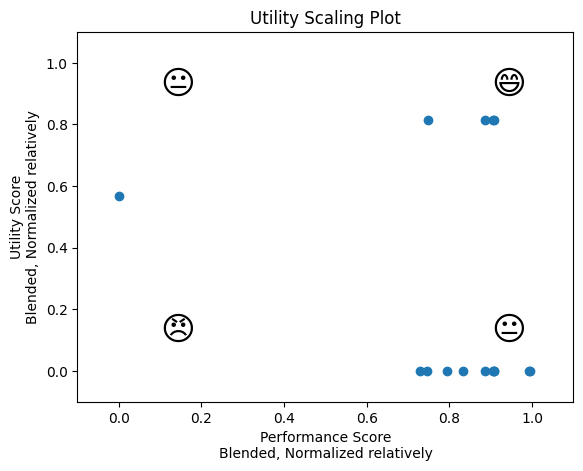

In [25]:
# create scatterplot

# note that we have multiple attempts to "solve" one benchmark_instance.

utility_scores = []
performance_scores = []
for p in perf_metrics_list:
    
    p_score = blended_performance_metric_score(
        p,
        performance_data_ranges,
        perf_metric_score_weights
    )
    performance_scores.append(p_score)

    # locate and score the corresponding benchmark instance for utility
    benchmark_instance_uuid = p["instance_uuid"]
    b = {}
    for b in instance_data_list:
        if b["metadata"]["instance_uuid"] == benchmark_instance_uuid:
            break
    u_score = blended_utility_score(
       b,
       instance_data_ranges,
       utility_score_weights
    )
    utility_scores.append(u_score)



plt.scatter(performance_scores, utility_scores)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.text(0.1, 0.1, s=u'\U0001F620', fontsize=24) # frown face
plt.text(0.1, 0.9, s=u'\U0001F610', fontsize=24) # no opinion face
plt.text(0.9, 0.1, s=u'\U0001F610', fontsize=24) # no opinion face
plt.text(0.9, 0.9, s=u'\U0001F604', fontsize=24) # happy face
plt.xlabel("Performance Score\nBlended, Normalized relatively")
plt.ylabel("Utility Score\nBlended, Normalized relatively")
plt.title("Utility Scaling Plot")

plt.show()

